**The IRIS DataSet**

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['database.sqlite', 'Iris.csv']


**Preparing Data**

In [4]:
file = '../input/Iris.csv'
df = pd.read_csv(file)
df = df.drop('Id',axis=1)
df = df.rename(columns={'Species':'Label'})

**Train-Test-Split Function**

In [5]:
def train_test_split(df,test_size):
    if isinstance(test_size, float):
        test_size = int(test_size*len(df))

    indices = list(df.index)
    test_indices = random.sample(indices, test_size)
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

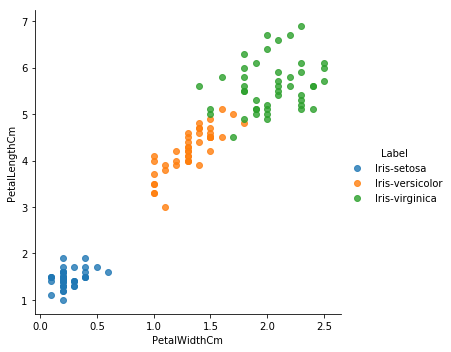

In [6]:
train_df, test_df = train_test_split(df, 0.1)
data = train_df.values           #making a numpy array for faster 
sns.lmplot(data=train_df, x = "PetalWidthCm", y = "PetalLengthCm", hue="Label", fit_reg=False)

**Check for Data Purity**

In [7]:
def check_purity(data):
    label_column = data[:,-1]
    unique_classes = np.unique(label_column)
    
    if len(unique_classes) == 1:
        return True
    else:
        return False

**Classify**

In [8]:
def classify_data(data):
    label_column = data[:,-1]
    unique_classes, count_unique_classes = np.unique(label_column, return_counts=True)
    classification = unique_classes[count_unique_classes.argmax()]
    return classification

**Potential Splits**

In [9]:
def get_potential_splits(data):
    
    potential_splits = {}
    _,n_columns = data.shape
    for index in range(n_columns-1):
        potential_splits[index] = []
        values = np.unique(data[:,index])
        for i in range(1,len(values)):
            prev_val = values[i-1]
            this_val = values[i]
            mid_val = (prev_val+this_val)/2
            potential_splits[index].append(mid_val)
    return potential_splits

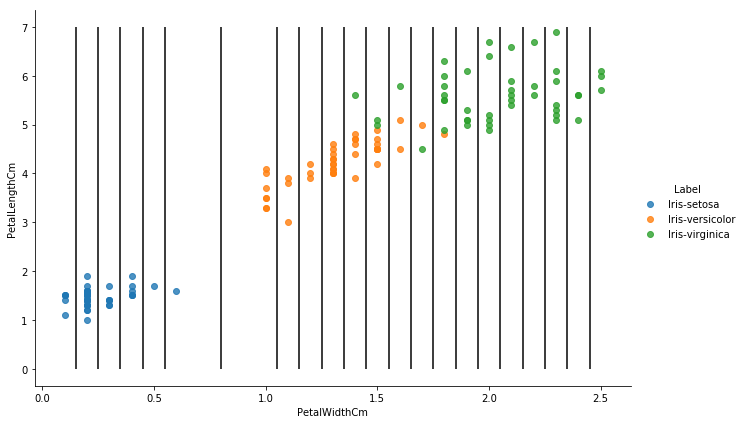

In [10]:
splits = get_potential_splits(train_df.values)
sns.lmplot(data=train_df, x = "PetalWidthCm", y = "PetalLengthCm", hue="Label", fit_reg=False, height = 6, aspect = 1.5)
plt.vlines(x=splits[3], ymin = 0, ymax = 7)

**Split Data**

In [11]:
def split_data(data, split_column, split_value):
    
    split_column_value = data[:, split_column]
    
    data_below = data[split_column_value <= split_value]
    data_above = data[split_column_value > split_value]
    
    return data_below, data_above

In [ ]:
# data_below, data_above = split_data(data, 3, 0.8)
# t = pd.DataFrame(data_below)
# t.columns = train_df.columns
# sns.lmplot(data=t, x = "PetalWidthCm", y = "PetalLengthCm", hue="Label", fit_reg=False, height = 6, aspect = 1.5)
# plt.vlines(x = 0.8, ymin = 0, ymax = 7.5)
# plt.xlim(0,2.6)

**Lowest Overall Entropy**

In [12]:
def calculate_entropy(data):
    label_column = data[:,-1]
    _, counts = np.unique(label_column, return_counts = True)
    total = counts.sum()
    probabilities = counts/total
    entropy = sum(-probabilities*np.log2(probabilities))
    return entropy

In [13]:
def calculate_overall_entropy(data_below, data_above):
    
    total = len(data_below)+len(data_above)
    p = len(data_below)/total
    q = len(data_above)/total

    overall_entropy = p*calculate_entropy(data_below) + q*calculate_entropy(data_above)
    
    return overall_entropy

In [14]:
def determine_best_split(data, potential_splits):
    overall_entropy = 1000
    for column in splits:
        for value in splits[column]:
            data_below, data_above = split_data(data, column, value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column
                best_split_value = value
    return best_split_column, best_split_value

In [15]:
determine_best_split(data,splits)

(3, 0.8)

**Decision Tree Algorithm**

In [30]:
def decision_tree_algorithm(df, counter = 0, min_samples = 2):
    
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df
    
    #base case
    if (check_purity(data)) or (len(data) < min_samples):
        classification = classify_data(data)
        return classification
    
    else:
        counter += 1
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        question = "{} <= {}".format(COLUMN_HEADERS[split_column], split_value)
        subtree = {question:[]}
        
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples)
        
        if yes_answer == no_answer:
            subtree = yes_answer
        else:
            subtree[question].append(yes_answer)
            subtree[question].append(no_answer)
        
        return subtree

In [36]:
tree = decision_tree_algorithm(train_df, min_samples = 7)
tree

{'PetalWidthCm <= 0.8': ['Iris-setosa',
  {'PetalLengthCm <= 4.85': ['Iris-versicolor',
    {'PetalWidthCm <= 1.75': [{'PetalLengthCm <= 5.55': ['Iris-versicolor',
        'Iris-virginica']},
      'Iris-virginica']}]}]}

**Classification**

In [37]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature, comparison, value = question.split()

    if example[feature] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    if not isinstance(answer, dict):
        return answer
    else:
        return classify_example(example, answer)
    
question = list(tree.keys())[0]
feature, comparison, value = question.split()
print(question)
print(feature)
print(comparison)
print(value)

PetalWidthCm <= 0.8
PetalWidthCm
<=
0.8


**Consider an example**

In [38]:
example = train_df.loc[1]
print(example)

SepalLengthCm            4.9
SepalWidthCm               3
PetalLengthCm            1.4
PetalWidthCm             0.2
Label            Iris-setosa
Name: 1, dtype: object


In [39]:
# Classifying using our tree

classify_example(example, tree)

'Iris-setosa'

**Accuracy**

In [40]:
def calc_accuracy(df, tree):
    
    df["Classification"] = df.apply(classify_example, axis = 1, args = (tree,))
    df['Correct_Classification'] = df.Classification == df.Label

    accuracy = df.Correct_Classification.mean()
    
    return accuracy

In [41]:
print("Train data accuracy = ",calc_accuracy(train_df, tree))
print("Test data accuracy = ",calc_accuracy(test_df, tree))

Train data accuracy =  0.9777777777777777
Test data accuracy =  0.8666666666666667
